In [1]:
import os
import pandas as pd

# Define the paths to the saved datasets
data_folder = os.path.join("..", "data", "processed")
X_train_path = os.path.join(data_folder, "X_train.csv")
X_test_path = os.path.join(data_folder, "X_test.csv")
y_train_path = os.path.join(data_folder, "y_train.csv")
y_test_path = os.path.join(data_folder, "y_test.csv")

# Load the datasets
X_train_filtered = pd.read_csv(X_train_path)
X_test_filtered = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path).squeeze()  # Convert to Series
y_test = pd.read_csv(y_test_path).squeeze()  # Convert to Series

# Verify the loaded data
print("Shapes of Loaded Data:")
print(f"X_train: {X_train_filtered.shape}, X_test: {X_test_filtered.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Shapes of Loaded Data:
X_train: (14, 49), X_test: (4, 49)
y_train: (14,), y_test: (4,)


In [2]:
# Dropping the columns as they do not contribute to the predictions
X_train_filtered.drop(columns=['Player', 'Date of birth/Age'], inplace=True)
X_test_filtered.drop(columns=['Player', 'Date of birth/Age'], inplace=True)

In [3]:
categorical_columns = ['Position', 'Foot', 'Contract', 'Nat.', 'Age_Group']

# Apply one-hot encoding
X_train_filtered = pd.get_dummies(X_train_filtered, columns=categorical_columns, drop_first=True)
X_test_filtered = pd.get_dummies(X_test_filtered, columns=categorical_columns, drop_first=True)

# Ensure the test set has the same columns as the train set
X_test_filtered = X_test_filtered.reindex(columns=X_train_filtered.columns, fill_value=0)

In [4]:
# converting height from string to float
X_train_filtered['Height'] = X_train_filtered['Height'].str.replace(',', '.', regex=False).str.replace('m', '').astype(float)
X_test_filtered['Height'] = X_test_filtered['Height'].str.replace(',', '.', regex=False).str.replace('m', '').astype(float)

In [5]:
# Identify numeric columns in X_train
import sys
from matplotlib import pyplot as plt
import numpy as np


numeric_features = X_train_filtered.select_dtypes(include=['float64', 'int64']).columns

# Define a function to handle outliers using IQR
def handle_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap values outside the bounds
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Apply the function to handle outliers in X_train and X_test
X_train_filtered = handle_outliers(X_train_filtered, numeric_features)
X_test_filtered = handle_outliers(X_test_filtered, numeric_features)

In [6]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Step 1: Interaction Terms
X_train_filtered['Goals_Assists'] = X_train_filtered['Goals'] * X_train_filtered['Assists']
X_test_filtered['Goals_Assists'] = X_test_filtered['Goals'] * X_test_filtered['Assists']

# Step 2: Polynomial Features (only for key features like Goals, Assists)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = ['Goals', 'Assists', 'Progressive_Passes']
X_train_poly = pd.DataFrame(poly.fit_transform(X_train_filtered[poly_features]), columns=poly.get_feature_names_out(poly_features))
X_test_poly = pd.DataFrame(poly.transform(X_test_filtered[poly_features]), columns=poly.get_feature_names_out(poly_features))

# Concatenate polynomial features with the original dataset
X_train_filtered = pd.concat([X_train_filtered, X_train_poly], axis=1)
X_test_filtered = pd.concat([X_test_filtered, X_test_poly], axis=1)

# Step 3: Initialize the model for RFE
base_model = XGBRegressor(random_state=42)

# Step 4: Perform RFE
rfe = RFE(estimator=base_model, n_features_to_select=10)  # Choose top 10 features
rfe.fit(X_train_filtered, y_train)

# Step 5: Get selected features
selected_features = pd.Index(X_train_filtered.columns[rfe.support_])  # Convert to Pandas Index for easy manipulation

# Step 6: Replace problematic features
problematic_features = ['Market value_scaled', '#']
replacement_features = ['Minutes_Played', 'Non_Penalty_Goals']  # Suggested replacements
selected_features = selected_features.difference(problematic_features)  # Drop problematic features
selected_features = selected_features.union(replacement_features)  # Add replacement features

print("Selected Features:", selected_features)

# Step 7: Filter the dataset with selected features
X_train_filtered = X_train_filtered[selected_features]
X_test_filtered = X_test_filtered[selected_features]

# Verify the filtered dataset
print("Filtered X_train shape:", X_train_filtered.shape)
print("Filtered X_test shape:", X_test_filtered.shape)

Selected Features: Index(['Age', 'Assists', 'Contract_Jun 30, 2026', 'Contract_Jun 30, 2029',
       'Goals', 'Matches_Played', 'Minutes_Played', 'Non_Penalty_Goals',
       'Starts', 'Yellow_Cards'],
      dtype='object')
Filtered X_train shape: (14, 12)
Filtered X_test shape: (4, 12)


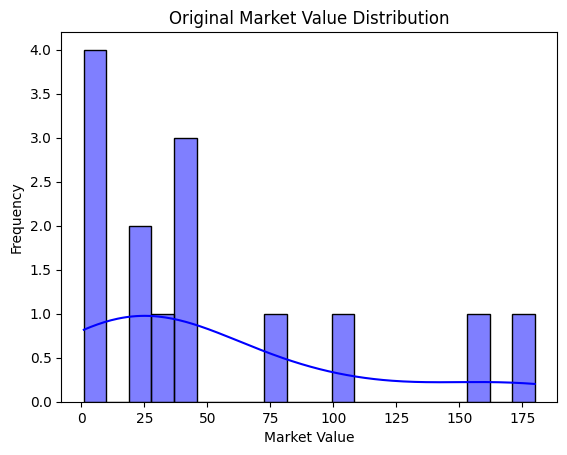

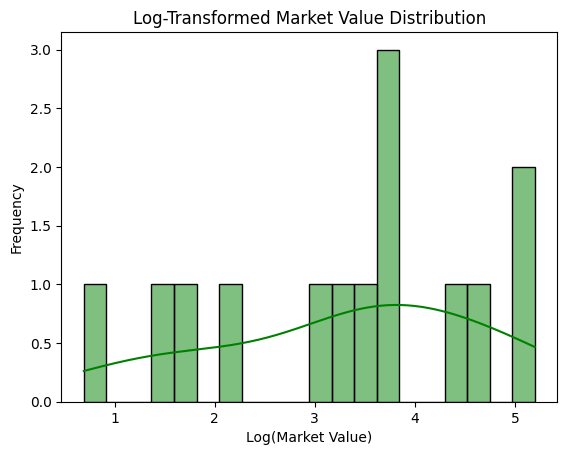

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Visualize the original Market Value distribution
sns.histplot(y_train, kde=True, bins=20, color='blue')
plt.title('Original Market Value Distribution')
plt.xlabel('Market Value')
plt.ylabel('Frequency')
plt.show()

# Step 2: Apply log transformation to reduce skewness
# Ensure there are no negative values in y_train and y_test
if (y_train < 0).any() or (y_test < 0).any():
    raise ValueError("Target values contain negative values, cannot apply log transformation.")

y_train_log = np.log1p(y_train)  # Apply log(x+1) transformation
y_test_log = np.log1p(y_test)

# Step 3: Visualize the log-transformed Market Value distribution
sns.histplot(y_train_log, kde=True, bins=20, color='green')
plt.title('Log-Transformed Market Value Distribution')
plt.xlabel('Log(Market Value)')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Ensure all column names are strings
X_train_filtered.columns = X_train_filtered.columns.astype(str)
X_test_filtered.columns = X_test_filtered.columns.astype(str)

# Remove problematic characters and replace spaces with underscores
X_train_filtered.columns = (
    X_train_filtered.columns.str.replace(r"[\\[\\]<>,.]", "", regex=True)
    .str.replace(r"\s+", "_", regex=True)
)
X_test_filtered.columns = X_train_filtered.columns  # Ensure alignment


In [9]:
# Append unique indices to any duplicates
X_train_filtered.columns = pd.Index([
    f"{col}_{i}" if X_train_filtered.columns.duplicated()[i] else col
    for i, col in enumerate(X_train_filtered.columns)
])
X_test_filtered.columns = X_train_filtered.columns  # Ensure alignment

# Check if all columns are unique
assert X_train_filtered.columns.is_unique, "Feature names in X_train are not unique!"
assert X_test_filtered.columns.equals(X_train_filtered.columns), "Feature names in X_test do not match X_train!"


In [10]:
# Check if X_train and y_train_log have matching row counts
if X_train_filtered.shape[0] != y_train_log.shape[0]:
    raise ValueError("Mismatch between number of rows in X_train and y_train_log")

In [11]:
# Replace additional problematic characters
X_train_filtered.columns = (
    X_train_filtered.columns.str.replace(r"[\\[\\]\"'<>]", "", regex=True)
    .str.replace(",", "_", regex=True)  # Replace commas with underscores
)
X_test_filtered.columns = X_train_filtered.columns

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Step 1: Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Step 2: Initialize RandomizedSearchCV
class XGBRegressorPatched(XGBRegressor):
    def __sklearn_tags__(self):
        return {}

random_search = RandomizedSearchCV(
    estimator=XGBRegressorPatched(random_state=42),
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Clean feature names
X_train_filtered.columns = (
    X_train_filtered.columns.astype(str)                         # Ensure names are strings
    .str.replace(r"[\\[\\]<>,.]", "", regex=True)       # Remove invalid characters
    .str.replace(r"\s+", "_", regex=True)              # Replace spaces with underscores
)

# Append unique suffixes to duplicates
X_train_filtered.columns = pd.Index([f"{col}_{i}" if X_train_filtered.columns.duplicated()[i] else col for i, col in enumerate(X_train_filtered.columns)])

# Align feature names in X_test
X_test_filtered.columns = X_train_filtered.columns

# Step 3: Fit the model to the training data
print("Starting hyperparameter tuning...")
random_search.fit(X_train_filtered, y_train_log)

# Step 4: Output the best parameters and scores
print("\nBest Parameters Found:")
print(random_search.best_params_)
print(f"Best Cross-Validation MAE (Log Scale): {-random_search.best_score_:.2f}")

# Step 5: Train the model with early stopping using the best parameters
print("\nTraining the final model with early stopping...")
best_params = random_search.best_params_

best_model = XGBRegressor(
    random_state=42,
    **best_params
)

best_model.fit(
    X_train_filtered, y_train_log,
    eval_set=[(X_test_filtered, y_test_log)],
    eval_metric="mae",
    early_stopping_rounds=10,
    verbose=True
)

Starting hyperparameter tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Parameters Found:
{'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Cross-Validation MAE (Log Scale): 0.87

Training the final model with early stopping...
[0]	validation_0-mae:3.14852
[1]	validation_0-mae:2.96128
[2]	validation_0-mae:2.78359
[3]	validation_0-mae:2.62024
[4]	validation_0-mae:2.39191
[5]	validation_0-mae:2.25421
[6]	validation_0-mae:2.06071
[7]	validation_0-mae:1.94779
[8]	validation_0-mae:1.78327
[9]	validation_0-mae:1.70809
[10]	validation_0-mae:1.55913
[11]	validation_0-mae:1.42209
[12]	validation_0-mae:1.31879
[13]	validation_0-mae:1.21648
[14]	validation_0-mae:1.12690
[15]	validation_0-mae:1.04382
[16]	validation_0-mae:0.96677
[17]	validation_0-mae:0.93493
[18]	validation_0-mae:0.86731
[19]	validation_0-mae:0.80460
[20]	validation_0-mae:0.76190
[21]	validation_0-mae:0.70803

c:\Users\mehra\anaconda3\envs\the_one\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\mehra\anaconda3\envs\the_one\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1.5, ...)

In [13]:
# Step 6: Evaluate the model on the test set
y_pred_log = best_model.predict(X_test_filtered)
y_pred = np.expm1(y_pred_log)  # Convert back to the original scale
y_test_original = np.expm1(y_test_log)

mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("\nFinal Model Performance on Test Set:")
print(f"  MAE: {mae:.2f}")
print(f"  MSE: {mse:.2f}")
print(f"  R² Score: {r2:.2f}")


Final Model Performance on Test Set:
  MAE: 6.88
  MSE: 94.69
  R² Score: 0.95


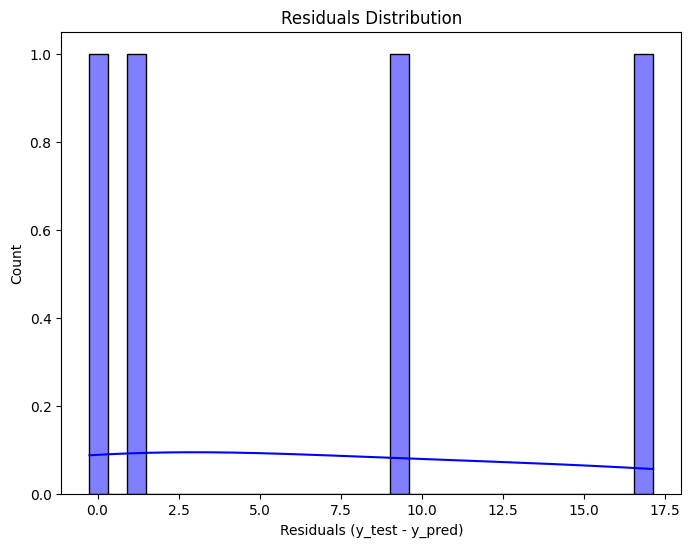

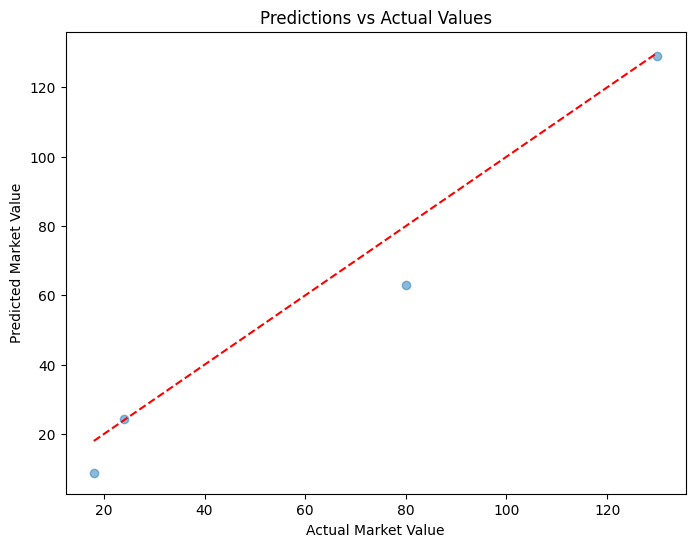

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Residuals Distribution")
plt.xlabel("Residuals (y_test - y_pred)")
plt.show()

# Scatter plot of predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("Predictions vs Actual Values")
plt.xlabel("Actual Market Value")
plt.ylabel("Predicted Market Value")
plt.show()


In [15]:
# Assuming best_model is the trained XGBRegressor
feature_importances = best_model.feature_importances_
features = X_train_filtered.columns

In [16]:
# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

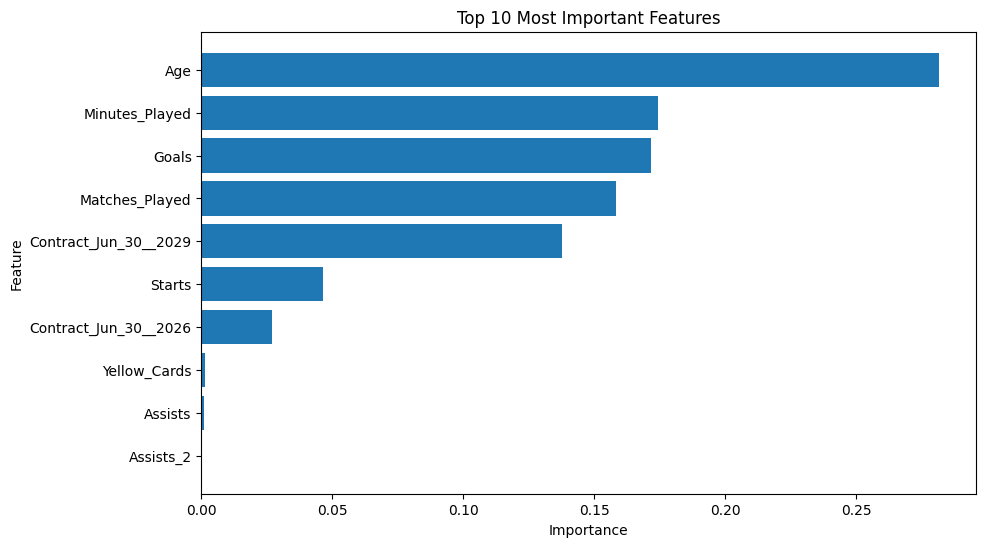

In [17]:
import matplotlib.pyplot as plt

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.gca().invert_yaxis()  # Invert the order for better readability
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()

In [18]:
# Create a DataFrame for features and their importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display each feature with its importance
print("Feature Importances (sorted):")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

Feature Importances (sorted):
Age: 0.2819
Minutes_Played: 0.1745
Goals: 0.1717
Matches_Played: 0.1584
Contract_Jun_30__2029: 0.1378
Starts: 0.0466
Contract_Jun_30__2026: 0.0270
Yellow_Cards: 0.0012
Assists: 0.0010
Assists_2: 0.0000
Goals_6: 0.0000
Non_Penalty_Goals: 0.0000


In [19]:
# Sum of all feature importances
total_importance = importance_df['Importance'].sum()
print(f"Total Feature Importance Score: {total_importance:.4f}")

Total Feature Importance Score: 1.0000
